In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Training Deep Neural Networks

Why would we need to use a deep neural net? Well say we are tackling a complex problem such as playing the gam eof go or generating auto-text. It can not actually be done well with shallow neural net. It is preferable to use a deep neural net. 

However it is difficult to train deep neural nets below are some problems you can face:

* You may be faced with the tricky vanishing gradient problem or the related exploding gradient problem. This is when teh gradients grow smaller and smaller or larger and larger, when folowing backward through the DNN during training. Both of these problems make lower layers very hard to train. 

* You might not have enough training for such a large netowrk, or it might be too costly to label.

* Training may be extremely slow.

* A model with millions of parameters would severly risk overfitting the training set, especially if there are not enough training instances or if they are too noisy. 

## The Vanishing/Exploding Gradient Problems

Backpropagation works by going back from the output layer to th einput layer propagating the error gradient along the way. Once the algorithm has computed the gradient the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with the gradient descent step. 

The problem with this approach with deep neural nets is that as the gradients gets smaller as you go down the lower layers meaning you never update the weights. The training never converges to a good solution.  This is called **vanishing graidents** problem. Sometimes the opposite happens and the gradients get bigger and bigger. Until the layers get insanely large weights and the alogrithm diverges. This is called **exploding graidents**. It is important to remember that different layers may learn at very different speeds. 


In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

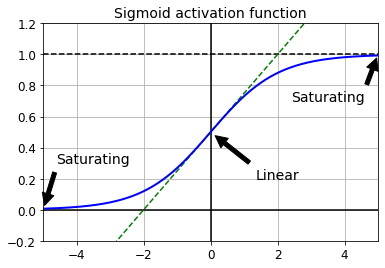

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

#save_fig("sigmoid_saturation_plot")
plt.show()

In the image above we see that when the inputs become large whether positive or negative the function saturates at 0 or 1 with a derivative extremely close to 0. When backpropagation kicks in it has varitually no gradient to progpagate back through the network and what little graidents exsts keeps getting diluted as backprogation progress down through the top layers so nothing left for the loower layers. 

## Glorot and He Initialization

In order to alleviate the unstable gradients problems. They point out that we need the signal  to flow properly in both directions: forward direction when making predictions and in the reverse direction when backpropagating gradients. We do not want the signal to die out nor do we want it to explode and saturate. 

For the signal to flow properly we need the variance of the outputs of each layer to be equal to the variance of inputs  and we need the gradients to have equal variance before an after flowing through a layer in the reverse direction. 

It is not actually possible to guarantee both they layer has an equal number of inputs and neurons these numbers are called the fan-in and fan-out of the layer. The solution to this was to make the connection weights of each layer innitialized randomly as described by fanavvg = (fanin + fanoout)/2. This initilization strategy is called Xavier initialization or Glorot initialization. 

Keras uses Glorot initialization with a uniform distribution. When creating a alyer, you can chnaget this to He initialization by setting **kernel_initializer="he_uniform"**.

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating activation Functions 

One of the reasons we had a problem with unstable gradients were in part due to poor activation function choices. The ReLu function works well because it does not saturate for paositive values and it is fast to compute. 

Some challenges with ReLu are that sometimes it just outputs 0. THis is called "dying ReLUs". This can happen if you have a large learning rate. 

Neurons die when its weights get tweaked in such a way that the weighted sum of is inputs are negative for all instances in the training set.  

To solve this problem you can use a variant of ReLU like "Leaky ReLU". The hyperparameter for the learning rate defines how much of the function "leaks". 

ReLU sometimes overfits on smaller datasets. 

### Leakly ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

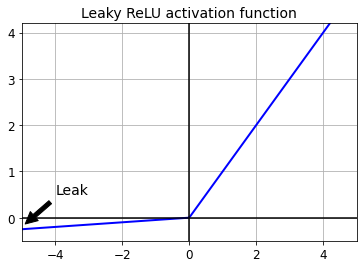

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

#save_fig("leaky_relu_plot")
plt.show()

In LeaklyReLU the hyperparameter alpha defines how much the functions leasks. The slope of the function for z <0 and is typically set to 0.01. THis small slope ensure sthst leakly ReLUs never die. Leakly ReLU always outperforms a strict ReLU activation function. IN fact if you set a higher alpha to 0.2 it may performance better than a 0.01 alpha parameters. Alpha is usually picked randomly. 

You can also have **PReLU** which is when the alpha parameter is learned during training. This is called parametric leakly ReLU. 

There is also another option called **exponential linear unit** a new activation fucntion that outperformed all ReLus. 

### ELU

In [9]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

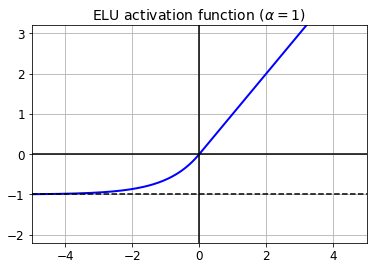

In [10]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

#save_fig("elu_plot")
plt.show()

THere are a few key differneces between ELU and RELU:

* It takes negative values when z < 0. This allows the unit to have a average output closer to 0. and helps alleviate the vanishing graident problem. The hyperparameter alpha defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1. But it can be tweaked.

* It has a nonzero graident for z < 0, which avoids the dead neuron problems.

* If alpha is equal to 1 then the function is smooth everywhere, including around z = 0, which helps spped up gradint descent. 

The main issue is that ELU is slower to compute. But there is a way around this using ScaledELU. Here if you build a neural network composed exclusively of a stack dense layers, and if all hidden layers uses SElu acivation function  then the network will self-normalize. The output of each layer will preserve a mean of 0 an dstandard deviation of 1 during training. Which solves the vanishing/exploding graident problem.  SELU the scaled variant of ELU outperforms other activation functions.  However in order for self normalization to happen the following needs to occur:

* The input features must be standardized
* Every hidden layer's weight must be initialized with LeCun normalization initialization.
* IN keras, this means seeting kernel_inittializer="lecun_normal"
* The network's architecture must be sequential. Unfortunately, if you try to use SELU in nonsequential architectures, such as recurrent networks. or networks with skip connections. Self normalization will not be guaranteed so SELu will not necessarily outperform other activation. 
* Self normalization only works oif all layers are dense. 

In [11]:
from scipy.special import erfc
# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [12]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

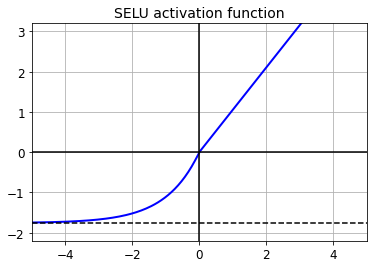

In [13]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

#save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [14]:
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


## Batch Normalization

Though we can use ELU and RELU to somlve the problem of vanishing/explording graidents, it does not guarantte they do not come back during training. 

To solve this we use Batch Normalization. This involves adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input then scales adn shifts the result using two new parameter vectors per layer: one for scaling and the othe rfor shifting. In other words, the operation lets the model learn the opitmal scale and mean of each layer's inputs. 